In [1]:
# Install spaCy (if not already installed)
#!pip install spacy

In [2]:
# Install pandas and scikit-learn for data handling and evaluation
#!pip install pandas scikit-learn

In [3]:
# Install nltk for advanced preprocessing
#!pip install nltk wordcloud

In [1]:
# Import libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import spacy
from spacy.pipeline.textcat import Config, single_label_bow_config
from spacy.training import Example
from spacy.util import minibatch, compounding
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix
import numpy as np
import random
import re
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [2]:
# Download necessary NLTK data
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/martawlusek/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/martawlusek/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/martawlusek/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/martawlusek/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
# Load train.csv
train_data = pd.read_csv("train.csv")

# Display the first few rows to understand the structure
train_data.head()


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
# Check for missing values and overall dataset structure
print("Missing values in the dataset:")
print(train_data.isnull().sum())

Missing values in the dataset:
id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64


In [5]:
# **EDA Section**
print("### Exploratory Data Analysis (EDA) ###")
# Dataset overview
print(f"Dataset Shape: {train_data.shape}")
print(train_data.info())
train_data.describe(include="all")

### Exploratory Data Analysis (EDA) ###
Dataset Shape: (159571, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB
None


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571,159571,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
unique,159571,159571,NaN,NaN,NaN,NaN,NaN,NaN
top,fff46fc426af1f9a,"""\nAnd ... I really don't think you understand...",NaN,NaN,NaN,NaN,NaN,NaN
freq,1,1,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,NaN,NaN,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [6]:
# Define input (comments) and output (labels)
X = train_data['comment_text']
y = train_data[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]  # Multiple labels for toxicity

# Inspect label distribution
print("Label distribution:")
print(y.value_counts())  # Check class counts

Label distribution:
toxic  severe_toxic  obscene  threat  insult  identity_hate
0      0             0        0       0       0                143346
1      0             0        0       0       0                  5666
                     1        0       1       0                  3800
                                      0       0                  1758
                     0        0       1       0                  1215
       1             1        0       1       0                   989
       0             1        0       1       1                   618
0      0             1        0       0       0                   317
                     0        0       1       0                   301
1      1             1        0       1       1                   265
0      0             1        0       1       0                   181
1      1             1        0       0       0                   158
       0             0        0       0       1                   136
          

In [7]:
# Split the data (80% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training samples: {len(X_train)}, Validation samples: {len(X_val)}")

# Display the distribution of labels in the training set
print("Training label distribution:")
print(y_train.sum())

# Display the distribution of labels in the validation set
print("Validation label distribution:")
print(y_val.sum())

Training samples: 127656, Validation samples: 31915
Training label distribution:
toxic            12238
severe_toxic      1274
obscene           6734
threat             404
insult            6263
identity_hate     1111
dtype: int64
Validation label distribution:
toxic            3056
severe_toxic      321
obscene          1715
threat             74
insult           1614
identity_hate     294
dtype: int64


/var/folders/b7/d_q5ksgd5jj2xntnvxy00ccw0000gn/T/ipykernel_22688/1996715200.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=label, data=train_data, palette="coolwarm")
/var/folders/b7/d_q5ksgd5jj2xntnvxy00ccw0000gn/T/ipykernel_22688/1996715200.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=label, data=train_data, palette="coolwarm")
/var/folders/b7/d_q5ksgd5jj2xntnvxy00ccw0000gn/T/ipykernel_22688/1996715200.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=label, data=train_data, palette="coolwarm")
/var/folders/b7/

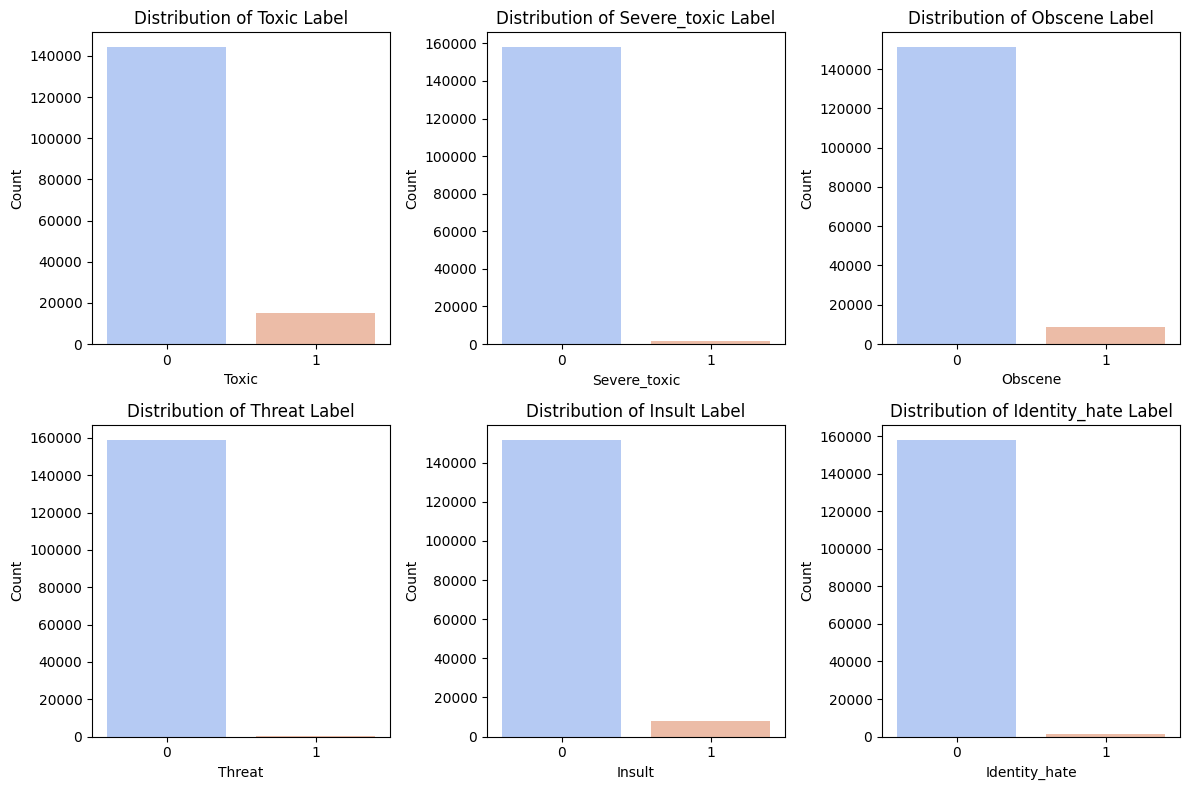

In [8]:
# Distribution of 'toxic' label
# List of labels
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# Create a bar plot for each label
plt.figure(figsize=(12, 8))

# Iterate over labels and plot distributions
for i, label in enumerate(labels, 1):
    plt.subplot(2, 3, i)  # Arrange plots in a 2x3 grid
    sns.countplot(x=label, data=train_data, palette="coolwarm")
    plt.title(f"Distribution of {label.capitalize()} Label")
    plt.xlabel(label.capitalize())
    plt.ylabel("Count")

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

In [9]:
# Inspect label distribution
print("Label distribution:")
print(y.sum())  # Check class counts

Label distribution:
toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64


Test 1: Undersampling

Combined Toxic Labels Distribution:
combined_toxic
0    143346
1     16225
Name: count, dtype: int64


/var/folders/b7/d_q5ksgd5jj2xntnvxy00ccw0000gn/T/ipykernel_22688/265498070.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='combined_toxic', data=balanced_data, palette="coolwarm")


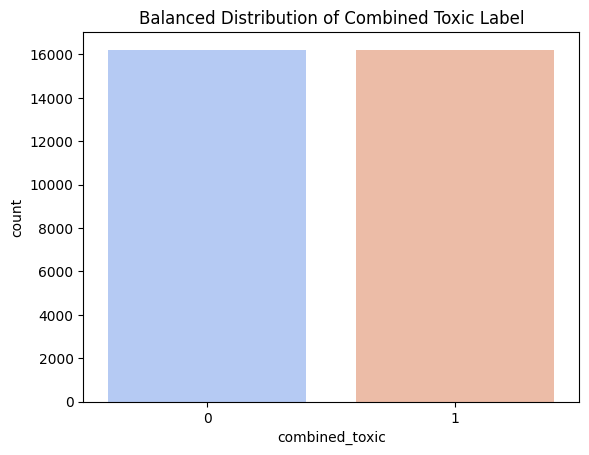

Sample of balanced data:
                                        comment_text  combined_toxic  toxic  \
0      You are an old cougar! You are an old cougar!               1      1   
1            I'm scared\nbrrrr.... i'm gonna die now               0      0   
2  Okay, so anal sex is as widely unaccepted and ...               1      1   
3  shut up you cunt\nWWWWWWWWWWWWWWWWWWWWWWWWWWWW...               1      1   
4  You arrogant administrator homosexual bastards...               1      1   

   severe_toxic  obscene  threat  insult  identity_hate  
0             0        0       0       1              0  
1             0        0       0       0              0  
2             0        0       0       0              0  
3             0        1       0       1              0  
4             1        1       0       1              1  


In [10]:
# Create a 'combined_toxic' label: 1 if any individual label is 1, else 0
train_data['combined_toxic'] = train_data[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].max(axis=1)

# Verify the new combined label distribution
print("Combined Toxic Labels Distribution:")
print(train_data['combined_toxic'].value_counts())

# Balance the combined toxic dataset (optional)
# Separate toxic and non-toxic comments
toxic_combined = train_data[train_data['combined_toxic'] == 1]
non_toxic_combined = train_data[train_data['combined_toxic'] == 0]

# Undersample non-toxic class to match the number of toxic samples
non_toxic_combined_undersampled = non_toxic_combined.sample(len(toxic_combined), random_state=42)

# Combine balanced data
balanced_data = pd.concat([toxic_combined, non_toxic_combined_undersampled], axis=0)

# Shuffle the dataset
balanced_data = balanced_data.sample(frac=1, random_state=42).reset_index(drop=True)

# Verify the new balanced label distribution
sns.countplot(x='combined_toxic', data=balanced_data, palette="coolwarm")
plt.title('Balanced Distribution of Combined Toxic Label')
plt.show()

# The dataset now has a 'combined_toxic' label for binary classification
# and the individual labels for multi-label classification
print("Sample of balanced data:")
print(balanced_data[['comment_text', 'combined_toxic', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].head())


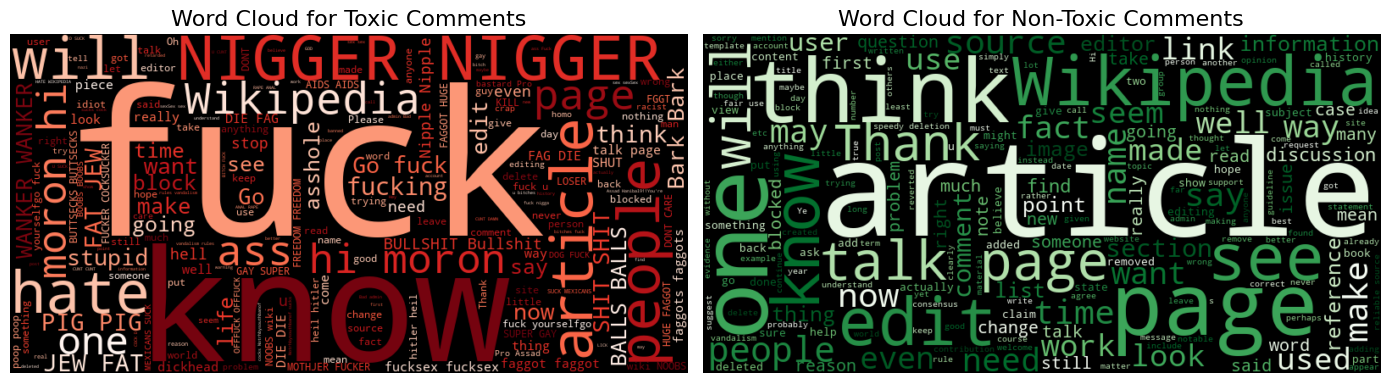

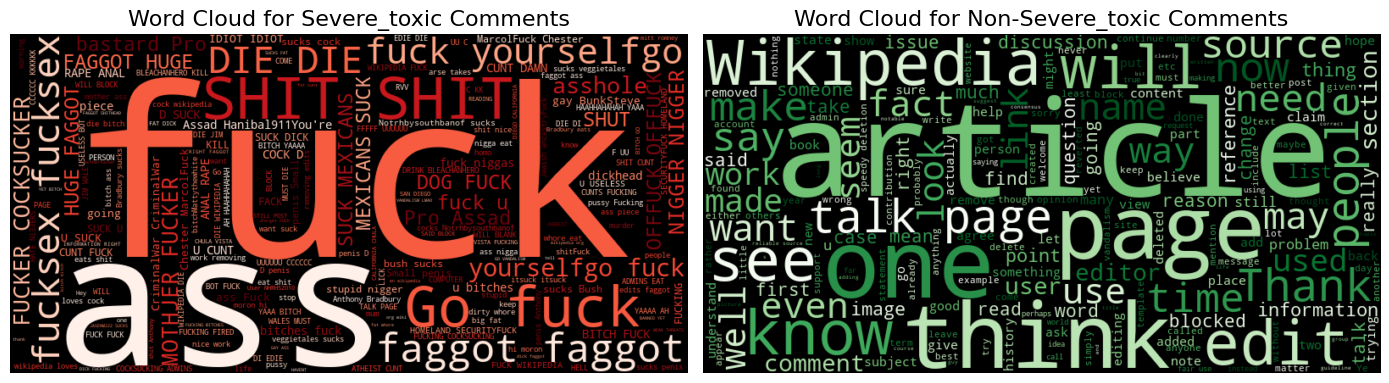

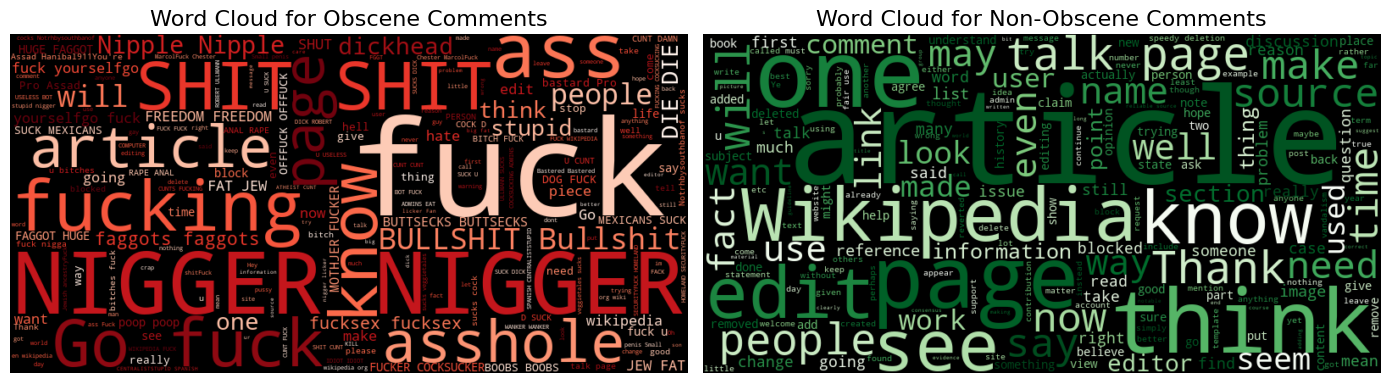

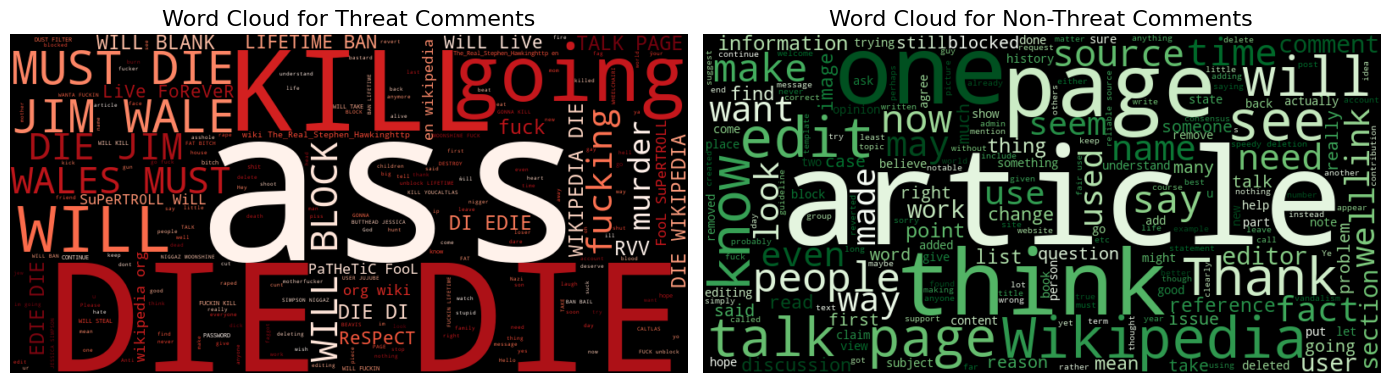

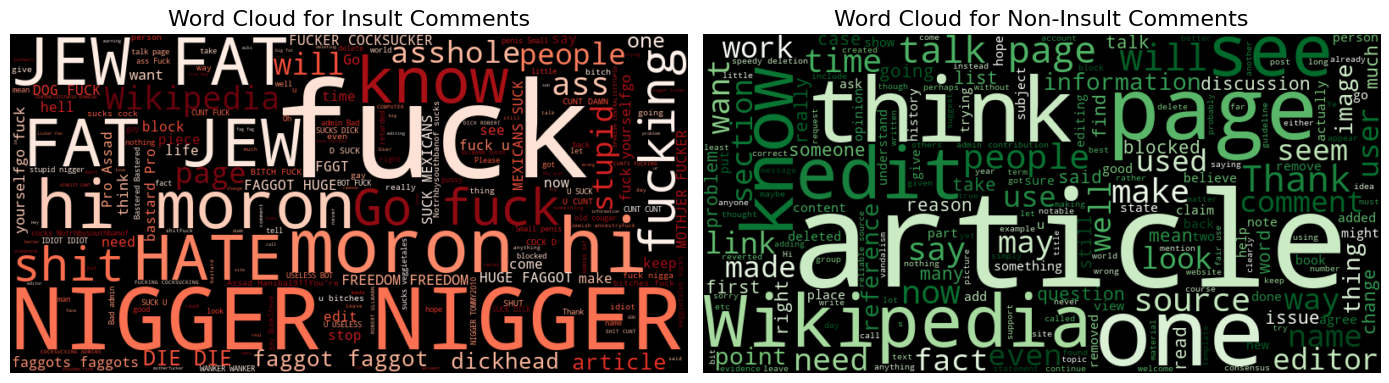

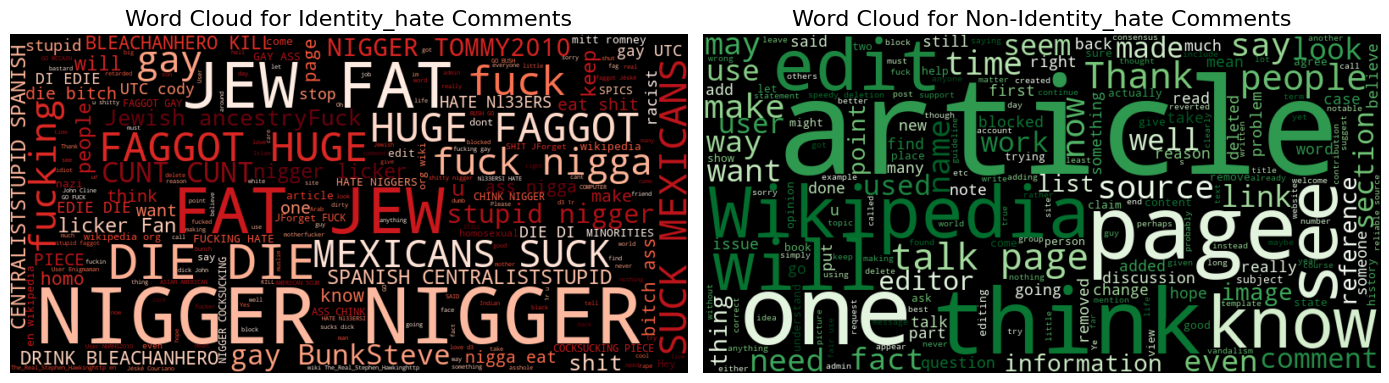

In [12]:
# Generate word clouds for each label
for label in labels:
    # Separate toxic and non-toxic comments for the current label
    toxic_text = " ".join(train_data[train_data[label] == 1]["comment_text"].astype(str).tolist())
    non_toxic_text = " ".join(train_data[train_data[label] == 0]["comment_text"].astype(str).tolist())
    
    # Create word clouds
    toxic_wordcloud = WordCloud(width=800, height=400, background_color='black', colormap='Reds').generate(toxic_text)
    non_toxic_wordcloud = WordCloud(width=800, height=400, background_color='black', colormap='Greens').generate(non_toxic_text)
    
    # Plot word clouds
    plt.figure(figsize=(14, 7))
    
    # Toxic word cloud
    plt.subplot(1, 2, 1)
    plt.imshow(toxic_wordcloud, interpolation='bilinear')
    plt.title(f"Word Cloud for {label.capitalize()} Comments", fontsize=16)
    plt.axis("off")
    
    # Non-toxic word cloud
    plt.subplot(1, 2, 2)
    plt.imshow(non_toxic_wordcloud, interpolation='bilinear')
    plt.title(f"Word Cloud for Non-{label.capitalize()} Comments", fontsize=16)
    plt.axis("off")
    
    plt.tight_layout()
    plt.show()


In [11]:
# Prepare 'non_toxic' label
train_data['non_toxic'] = ~(train_data[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].sum(axis=1) > 0).astype(int)

# Convert data into spaCy format
def prepare_spacy_data(comments, labels):
    spacy_data = []
    for comment, label_row in zip(comments, labels.itertuples(index=False)):
        # Create the 'cats' dictionary
        cats = label_row._asdict()  # Convert Pandas row to dictionary
        spacy_data.append((comment, {'cats': cats}))
    return spacy_data

# Prepare training and validation data for multi-label classification
train_data_spacy = prepare_spacy_data(X_train, y_train)
val_data_spacy = prepare_spacy_data(X_val, y_val)

# Print a sample of the processed data
print("Sample processed data (spaCy format):")
print(train_data_spacy[:3])

Sample processed data (spaCy format):
[('Grandma Terri Should Burn in Trash \nGrandma Terri is trash. I hate Grandma Terri. F%%K her to HELL! 71.74.76.40', {'cats': {'toxic': 1, 'severe_toxic': 0, 'obscene': 0, 'threat': 0, 'insult': 0, 'identity_hate': 0}}), (', 9 May 2009 (UTC)\nIt would be easiest if you were to admit to being a member of the involved Portuguese Lodge, and then there would be no requirement to acknowledge whether you had a previous account (Carlos Botelho did not have a good record) or not and I would then remove the sockpuppet template as irrelevant. WP:COI permits people to edit those articles, such as MSJapan does, but just means you have to be more careful in ensuring that references back your edits and that NPOV is upheld.   20:29', {'cats': {'toxic': 0, 'severe_toxic': 0, 'obscene': 0, 'threat': 0, 'insult': 0, 'identity_hate': 0}}), ('"\n\nThe Objectivity of this Discussion is doubtful (non-existent)\n\n(1) As indicated earlier, the section on Marxist leaders

In [12]:
# **Enhanced Preprocessing using NLTK**
def preprocess_text_nltk(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r"\s+", " ", text)  # Remove extra whitespaces
    text = re.sub(r"http\S+", "", text)  # Remove URLs
    text = re.sub(r"[^\w\s]", "", text)  # Remove punctuation

    # Tokenize
    tokens = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Lemmatize
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return ' '.join(tokens)

# Apply enhanced preprocessing to training and validation data
X_train_cleaned = X_train.apply(preprocess_text_nltk)
X_val_cleaned = X_val.apply(preprocess_text_nltk)

# Prepare spaCy data again with cleaned text
train_data_spacy = prepare_spacy_data(X_train_cleaned, y_train)
val_data_spacy = prepare_spacy_data(X_val_cleaned, y_val)

print("Sample cleaned data (spaCy format):")
print(train_data_spacy[:3])

Sample cleaned data (spaCy format):
[('grandma terri burn trash grandma terri trash hate grandma terri fk hell 71747640', {'cats': {'toxic': 1, 'severe_toxic': 0, 'obscene': 0, 'threat': 0, 'insult': 0, 'identity_hate': 0}}), ('9 may 2009 utc would easiest admit member involved portuguese lodge would requirement acknowledge whether previous account carlos botelho good record would remove sockpuppet template irrelevant wpcoi permit people edit article msjapan mean careful ensuring reference back edits npov upheld 2029', {'cats': {'toxic': 0, 'severe_toxic': 0, 'obscene': 0, 'threat': 0, 'insult': 0, 'identity_hate': 0}}), ('objectivity discussion doubtful nonexistent 1 indicated earlier section marxist leader view misleading lay unwarranted excessive emphasis trotsky creating misleading impression prominent marxist marx engels lenin advocate andor practiced terrorism b lay unwarranted excessive emphasis theoretical rejection individual terrorism creating misleading impression main marxi

In [17]:
# Save processed data to files (optional)
# import json

# with open("train_data_spacy.json", "w") as f:
#     json.dump(train_data_spacy, f)

# with open("val_data_spacy.json", "w") as f:
#     json.dump(val_data_spacy, f)

# print("Preprocessed data saved as JSON files.")

In [13]:
# Create a blank spaCy pipeline for English
nlp = spacy.blank("en")

# Print a confirmation
print("Blank spaCy pipeline created.")


Blank spaCy pipeline created.


In [14]:
config = {
    "threshold": 0.6,  # Classification threshold
    "model": {
        "@architectures": "spacy.TextCatEnsemble.v2",
        "tok2vec": {
            "@architectures": "spacy.Tok2Vec.v2",
            "embed": {
                "@architectures": "spacy.MultiHashEmbed.v2",
                "width": 64,
                "rows": [2000, 2000, 500, 1000, 500],
                "attrs": ["NORM", "LOWER", "PREFIX", "SUFFIX", "SHAPE"],
                "include_static_vectors": False,
            },
            "encode": {
                "@architectures": "spacy.MaxoutWindowEncoder.v2",
                "width": 64,
                "window_size": 1,
                "maxout_pieces": 3,
                "depth": 2,
            },
        },
        "linear_model": {
            "@architectures": "spacy.TextCatBOW.v3",
            "exclusive_classes": False,  # Multi-label classification
            "ngram_size": 1,
            "no_output_layer": False,
            "length": 262144,  # Add length explicitly to avoid further errors
        },
    },
}

# Add the multi-label text categorizer (textcat_multilabel)
textcat = nlp.add_pipe("textcat_multilabel", config=config)

analysis = nlp.analyze_pipes(pretty=True)
print(analysis)

# Add labels (categories) to the text categorizer
for label in y_train.columns:  # Assuming y_train.columns contains category names
    textcat.add_label(label)


============================= Pipeline Overview =============================

#   Component            Assigns    Requires   Scores            Retokenizes
-   ------------------   --------   --------   ---------------   -----------
0   textcat_multilabel   doc.cats              cats_score        False      
                                               cats_score_desc              
                                               cats_micro_p                 
                                               cats_micro_r                 
                                               cats_micro_f                 
                                               cats_macro_p                 
                                               cats_macro_r                 
                                               cats_macro_f                 
                                               cats_macro_auc               
                                               cats_f_per_type           

In [15]:
# Initialize optimizer
optimizer = nlp.begin_training()

# Training parameters
n_iter = 10  # Number of iterations

In [16]:
# Training loop
for epoch in range(n_iter):
    random.shuffle(train_data_spacy)  # Shuffle training data each epoch
    losses = {}
    
    # Create batches of data
    batches = minibatch(train_data_spacy, size=compounding(4.0, 32.0, 1.001))
    
    for batch in batches:
        examples = []
        for text, annotations in batch:
            # Create Example objects
            doc = nlp.make_doc(text)
            example = Example.from_dict(doc, {"cats": annotations["cats"]})  # Multi-label format
            examples.append(example)
        
        # Update the model with the batch of Example objects
        nlp.update(examples, drop=0.5, losses=losses)
    
    print(f"Epoch {epoch + 1}, Loss: {losses['textcat_multilabel']}")

Epoch 1, Loss: 118.96920310875137
Epoch 2, Loss: 71.1927127218978


KeyboardInterrupt: 

In [19]:
# Collect predictions and true labels
true_labels = []
pred_labels = []

# Loop through the validation data (with multi-labels)
for text, annotations in val_data_spacy:  # val_data_spacy is a list of (text, annotations)
    # Convert the text and annotations into an Example
    example = spacy.training.Example.from_dict(nlp.make_doc(text), {"cats": annotations["cats"]})
    
    # Process the text with the model
    doc = nlp(example.text)
    
    # Collect predictions for all labels, including 'non_toxic'
    predicted_cats = {label: doc.cats[label] for label in doc.cats}
    
    # Calculate 'non_toxic' for predictions
    predicted_cats['non_toxic'] = int(all(doc.cats[label] < 0.6 for label in doc.cats if label != 'non_toxic'))
    
    # Collect true labels for all categories, including 'non_toxic'
    true_cats = annotations["cats"].copy()
    true_cats['non_toxic'] = int(all(annotations["cats"][label] == 0 for label in annotations["cats"] if label != 'non_toxic'))
    
    # Append predictions and true labels
    pred_labels.append(predicted_cats)
    true_labels.append(true_cats)

# Convert predictions to binary based on threshold
threshold = 0.5
pred_binary = [
    {label: int(score >= threshold) for label, score in pred.items()}
    for pred in pred_labels
]

# Extract the keys (categories/labels) in a consistent order
categories = list(true_labels[0].keys())  # Includes all labels, including 'non_toxic'

# Convert dictionaries to 2D arrays for sklearn
true_array = np.array([[label_dict[cat] for cat in categories] for label_dict in true_labels])
pred_array = np.array([[label_dict[cat] for cat in categories] for label_dict in pred_binary])

# Evaluate using sklearn's classification report for multi-label classification
print(classification_report(true_array, pred_array, target_names=categories, zero_division=1))


               precision    recall  f1-score   support

        toxic       0.87      0.70      0.78      3056
 severe_toxic       0.55      0.02      0.04       321
      obscene       0.87      0.76      0.81      1715
       threat       1.00      0.00      0.00        74
       insult       0.74      0.68      0.71      1614
identity_hate       0.93      0.04      0.08       294
    non_toxic       0.96      0.99      0.98     28671

    micro avg       0.94      0.93      0.93     35745
    macro avg       0.85      0.46      0.49     35745
 weighted avg       0.94      0.93      0.92     35745
  samples avg       0.95      0.95      0.95     35745

